# Unsupervised Machine Learning: Clustering and Dimensionality Reduction

CSC/DSC 340 Week 6 Lecture Notes

Author: [Dr. Julie Butler](www.juliebutler.org)

Date Created: August 30, 2023

Last Modified: August 30, 2023

In [1]:
##############################
##          IMPORTS         ##
##############################
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.cm as cm
from sklearn.svm import SVC
import matplotlib.pyplot as plt
from scipy.stats import uniform
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.datasets import load_wine
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error as mse
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn.metrics import accuracy_score, classification_report

## Wine Data Set

In these lecture notes we will be investigating a new data set, called the wine data set.  This data set is provided by Scikit-Learn, it it already comes cleaned and formatted for machine learning. This data set contains 178 data points across three different labels and each data point as 13 features.  The features of each data point are quantifiable descriptions of the wine (such as color and chemical composition) and the labels are which of the three regions that wine comes from. The goal of this data set, phrased in a supervised learning context, is to predict which of the three regions the wine originated from. This data set does have come challenges however.  The different features have varying scales, meaning that scaling the data down to a consistent scale will likely be important.  Additionally, there are also class imbalances in the data that may make predicting one of the classes much more difficult due to a lack of data points.  Both of these challenges are found in real world data, so it is important to know how to deal with them.  

The differences in scaled data can be handled through any number of scaling methods, such as standard scaler which we have been using.  The class imbalance, depending on how skewed it is, can be handled by creating a data set that intentionally has roughly equal representations from all of the classes instead of creating the training set randomly, which may leave one or more classes unrepresented or underrepresented.

Let's import the data set from Scikit-learn and convert the data set to a Pandas array.

In [2]:
wine = load_wine()
wine_data = pd.DataFrame(data=wine.data, columns=wine.feature_names)
wine_data['labels'] = wine.target
wine_data

alcohol  malic_acid   ash  alcalinity_of_ash  magnesium  total_phenols  \
0      14.23        1.71  2.43               15.6      127.0           2.80   
1      13.20        1.78  2.14               11.2      100.0           2.65   
2      13.16        2.36  2.67               18.6      101.0           2.80   
3      14.37        1.95  2.50               16.8      113.0           3.85   
4      13.24        2.59  2.87               21.0      118.0           2.80   
..       ...         ...   ...                ...        ...            ...   
173    13.71        5.65  2.45               20.5       95.0           1.68   
174    13.40        3.91  2.48               23.0      102.0           1.80   
175    13.27        4.28  2.26               20.0      120.0           1.59   
176    13.17        2.59  2.37               20.0      120.0           1.65   
177    14.13        4.10  2.74               24.5       96.0           2.05   

     flavanoids  nonflavanoid_phenols  proanthocyanins  color_intensity   hue  \
0          3.06                  0.28             2.29             5.64  1.04   
1          2.76                  0.26             1.28             4.38  1.05   
2          3.24                  0.30             2.81             5.68  1.03   
3          3.49                  0.24             2.18             7.80  0.86   
4          2.69                  0.39             1.82             4.32  1.04   
..          ...                   ...              ...              ...   ...   
173        0.61                  0.52             1.06             7.70  0.64   
174        0.75                  0.43             1.41             7.30  0.70   
175        0.69                  0.43             1.35            10.20  0.59   
176        0.68                  0.53             1.46             9.30  0.60   
177        0.76                  0.56             1.35             9.20  0.61   

     od280/od315_of_diluted_wines  proline  labels  
0                            3.92   1065.0       0  
1                            3.40   1050.0       0  
2                            3.17   1185.0       0  
3                            3.45   1480.0       0  
4                            2.93    735.0       0  
..                            ...      ...     ...  
173                          1.74    740.0       2  
174                          1.56    750.0       2  
175                          1.56    835.0       2  
176                          1.62    840.0       2  
177                          1.60    560.0       2  

[178 rows x 14 columns]

Now let's create a pairplot of the data with the hue set to the type of wine to see if we can draw and conclusions about the clustering of the different wine categories.

/Users/butlerju/Library/Python/3.9/lib/python/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


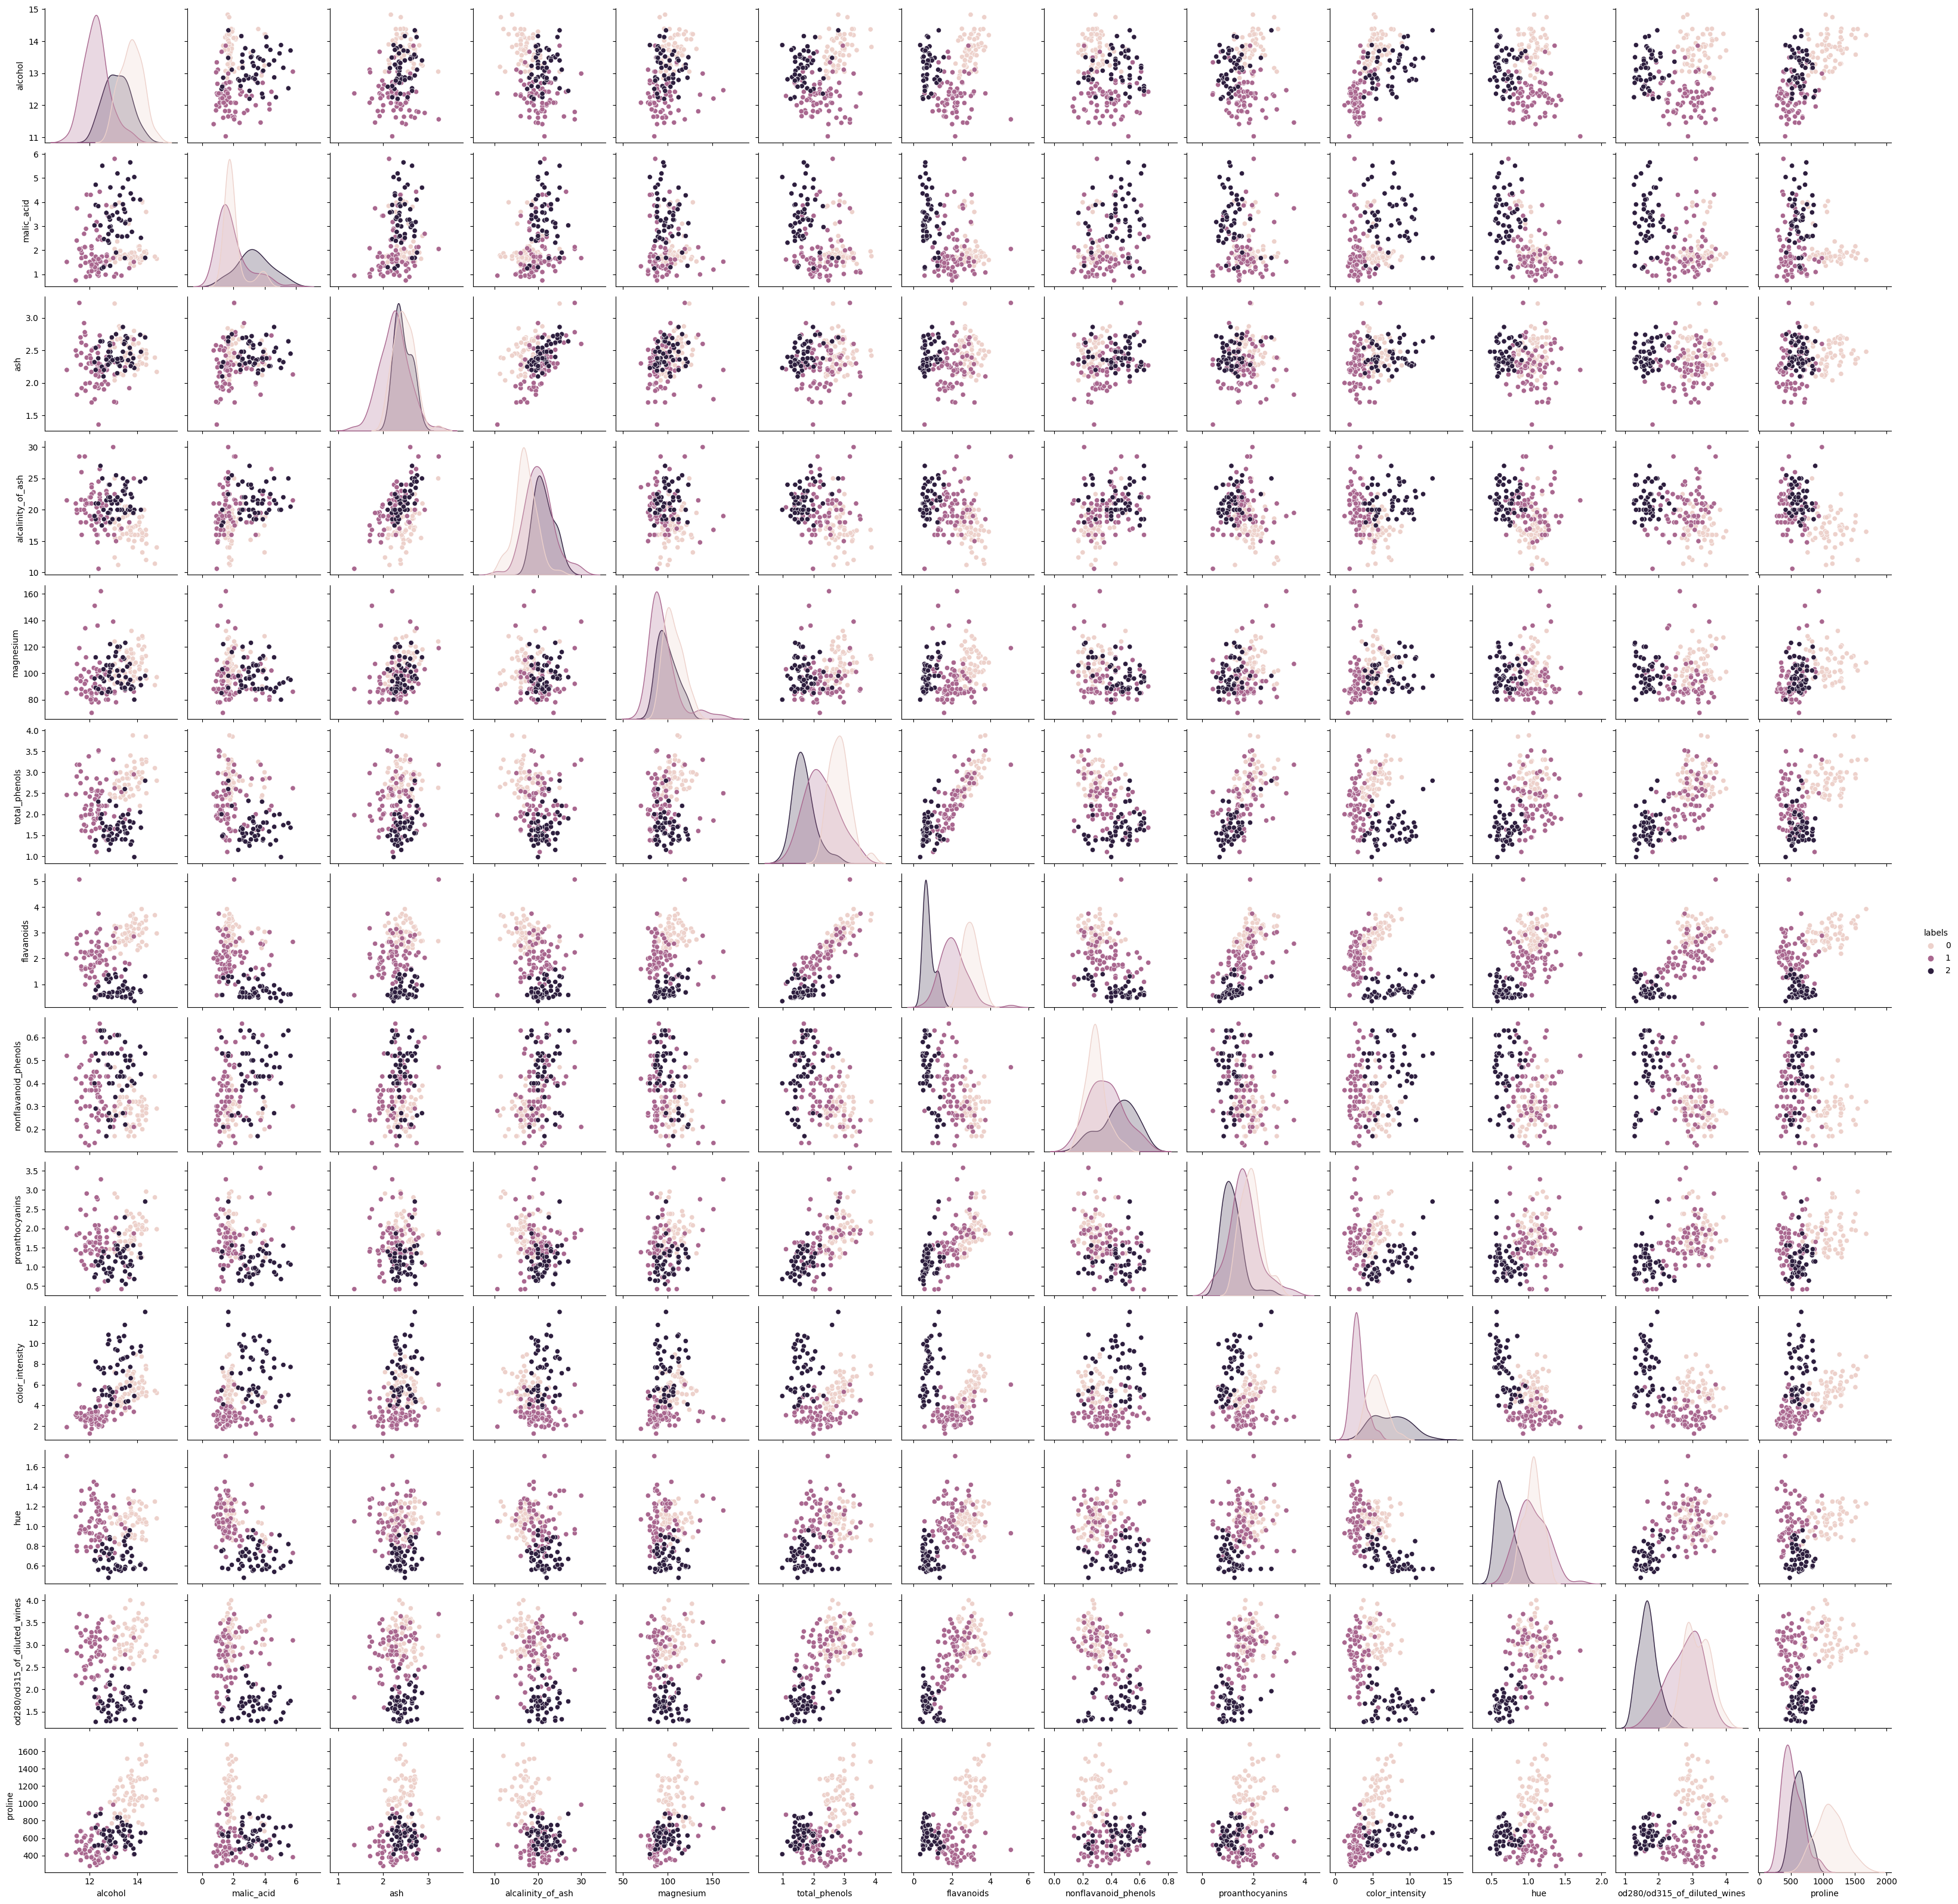

In [3]:
sns.pairplot(wine_data, hue='labels')

For some general observations, there are some plots in the pairplot where it will be hard to determine where a wine originated because the data overlaps so much.  However, there are also some plots which give us hope that we will be able to accurately classify the data because the wine classes are relatively distinct.  Now, lets train a classifier and see how well it will do.

## Support Vector Classifier

We will be using a new classifier for this data set, called the support vector classifier (SVC). SVC belongs to a class of algorithms called support vector machines, which is a relatively popular branch of machine learning algorithms.  SVC uses the kernel trick to modify its inputs, like the kernel ridge regression algorithm we studied last week, to add nonlinearity into itself, which should make it a better classifier than the ridge classifier when it comes to nonlinear patterns in the data. SVC is actually a binary classifier that works by finding a hyperplane in the feature space that separates the two classes of data. SVC can be extended to be a multiclass classifier using a One-vs-Rest approach, where it uses a binary classifier to decide if a data point belongs to class X or anything but class X.  You do not have to implement this as Scikit-Learn will do it automatically, but it is good to know how the classifier works as the One-vs-Rest approach may not be best for some data sets.

Let's train an SVC on the wine data set, first without using the standard scaler and then with using the standard scaler to see the difference in scaling the data.

In [4]:
X = np.asarray(wine_data.drop(columns=['labels']))
y = np.asarray(wine_data['labels'])

X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2)

svc = SVC(kernel='linear', C=1.0)
svc.fit(X_train, y_train)
y_pred = svc.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.2f}")

Accuracy: 0.94


In [5]:
scaler = StandardScaler()
scaler.fit(X)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)


svc = SVC(kernel='linear', C=1.0)
svc.fit(X_train, y_train)
y_pred = svc.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.2f}")

Accuracy: 0.97


The results will vary based on the random splitting, but we can consider these our baseline results that we will attempt to improve later in this notebook when we study dimensionality reduction.  However, we are first going to be looking at clustering, which is the unsupervised task related to classification.

## Clustering

### What is Unsupervised Learning?

Unsupervised learning describes a class of machine learning algorithms that draw patterns from unlabeled data, meaning that they only receive the features of the data set, not the targets/labels. The goal of these algorithms is to find patterns that are hidden in the features of the data set. Examples of tasks that can be performed by unsupervised learning methods are clustering (how many groups do the data points fall into?), dimensionality reduction (is it possible to reduce the number of features by eliminating some or combining the features?), and anomaly detection (is it possible to detect anomalies in a given data set).

### What is Clustering?

The first unsupervised learning technique we will be looking at is clustering. Clustering decides how many groups are present in a data set and into which category the data points fall.  It does this only by looking at the features, so it has no idea how many different groups are actually present in the data set. This does mean that if you know how many groups are present in the data set you may get some interesting results, but clustering is especially useful when you have data that you know is somehow grouped but you don't know how many categories you have or into what category each point falls. In these cases, you could use clustering to determine how many categories there are and into what category your current data falls. You can then use these results to train a supervised learning classification algorithm in order to classify future data. Examples of clustering algorithms are k-means (this notebook), hierarchical clustering analysis (HCA), and DBSCAN.

### k-Means (KMeans)
k-Means (or KMeans) is a clustering algorithm that partitions data into clusters based on similarities in the data points. It does this by following a rather short algorithm. The algorithm must be initialized with the number of clusters to find, and then the following steps occur.
1. _Initialize the Cluster Centroids._ The cluster centroids are points at the geometric center of each cluster.  Since we are not sure what are clusters are at this point, however, we randomly place the specified number of clusters in the feature space.
2. _Sort the Data._ Each data point is assigned to the closest centroid, being the center it has the shortest distance to in feature space.
3. _Update the Centroids._ Once the clusters have been defined, the locations of the centroids are updated to be the geometric center of each cluster in the feature space.
4. _Repeat._ Steps 2 and 3 are repeated in sequence until the algorithm has converged (meaning the centroids are not moving significantly between iterations).

![kmeans](https://media.licdn.com/dms/image/C5612AQH8kEizAouznA/article-cover_image-shrink_600_2000/0/1626424726069?e=2147483647&v=beta&t=deUL_yPDFPXK8dkspX2oJZWX1qqyx3XBokl02TN8x9k)

#### Measure of Success
Since k-means is an unsupervised algorithm, we cannot measure success in the same way we would a supervised algorithm.  Since supervised algorithms have known labels/targets using success metrics like the mean-squared error score or the accuracy score.  With unsupervised learning, we do not have error or accuracy scores, but we do have metrics that we can use to determine the performance of the algorithms.  For k-means, we can use a metric called the within-cluster sum of squares (WCSS) (also called inertia) to determine its success in clustering the data. This is the sum of the squared distance between each data point and the centroid of its cluster. Essentially, it is a measure of the compactness of the clusters.  A high inertia score means the clusters are quite spread out, which may actually be the case but is also a reason to second guess the clusters given by the algorithm. We will see a bit later in this notebook how the inertia score can be used to determine how many clusters are in the data set if the number is unknown.

### Assuming we know the number of clusters

Let's first analyze the wine data set with k-means assuming we know the number of clusters (3).  Knowing this we can define a k-means algorithm, train it, and then extract the predicted labels for each of the data points.

In [6]:
n_clusters = 3
kmeans = KMeans(n_clusters=n_clusters, n_init='auto')

# Fit the KMeans model
kmeans.fit(X)

# Predict the clusters
cluster_labels = kmeans.labels_

Now that we have our clusters and labels for each data point, we can create a plot of two of the features and color each data point to match its corresponding label.

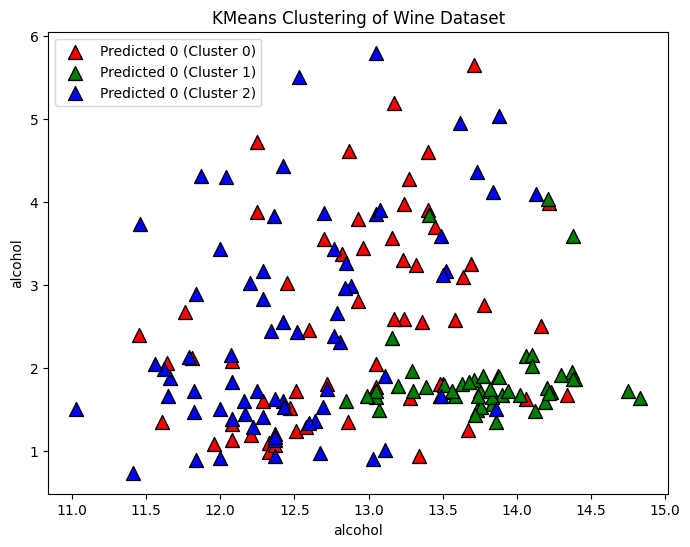

In [7]:
# Plot the clusters
plt.figure(figsize=(8, 6))
for i, color in zip(range(n_clusters), ['r', 'g', 'b']):
    predicted_indices = np.where(cluster_labels == i)
    plt.scatter(X[predicted_indices, 0], X[predicted_indices, 1], c=color, label=f'Predicted {y[i]} (Cluster {i})', marker='^', edgecolors='k', s=100)

plt.xlabel(wine.feature_names[0])
plt.ylabel(wine.feature_names[0])
plt.title('KMeans Clustering of Wine Dataset')
plt.legend()

We can also plot the true categories on each plot.  Remember that since k-means is an unsupervised learning algorithm, we cannot talk about the error or the accuracy in the predictions, but we can still look at the expected clusters as a comparison.  The labels of the data is are the origin of the wine, we when we know that we are looking for patterns in the data that support it. The k-means does not know what the labels are, only that it must divide the data into three different clusters. Therefore, these clusters may not correspond to wine origin, but some other similarities in the data.

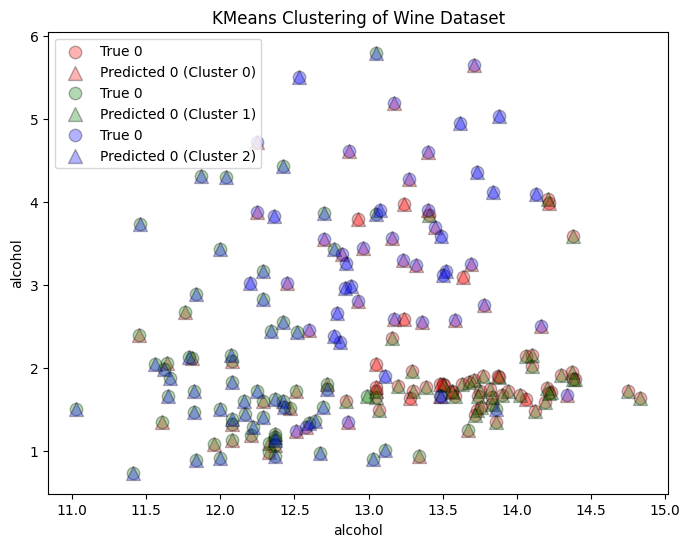

In [8]:
# Plot the clusters
plt.figure(figsize=(8, 6))
for i, color in zip(range(n_clusters), ['r', 'g', 'b']):
    true_indices = np.where(y == i)
    predicted_indices = np.where(cluster_labels == i)
    plt.scatter(X[true_indices, 0], X[true_indices, 1], c=color, label=f'True {y[i]}',  edgecolors='k', s=80, alpha=0.3)
    plt.scatter(X[predicted_indices, 0], X[predicted_indices, 1], c=color, label=f'Predicted {y[i]} (Cluster {i})', marker='^', edgecolors='k', s=100, alpha=0.3)

plt.xlabel(wine.feature_names[0])
plt.ylabel(wine.feature_names[0])
plt.title('KMeans Clustering of Wine Dataset')
plt.legend()
plt.show()

#### What if We Do Not Know the Number of Clusters?

If we were applying this method to a real data set, we either would not know the exact number of classifications in the data or we may be interested to see how many groups the clustering algorithm things best fits the data.  There are several methods that can be used to determine what the optimal number of clusters for the data set is and we will discuss two of them in this notebook. The first method we will be looking at is called hte elbow plot. This is a plot of the number of clusters used in the k-means algorithm plotted on the x-axis, and the WCSS score for each number of clusters on the y-axis. The goal of the plot is to find the "elbow", the point at which the reduction in WCSS (or the compactness of the clusters) starts to slow down as more clusters are added into the data.  The number of points at this elbow is the optimal number of clusters. We can make an elbow plot for the wine data for cluster numbers between 1 and 10 using the below code.

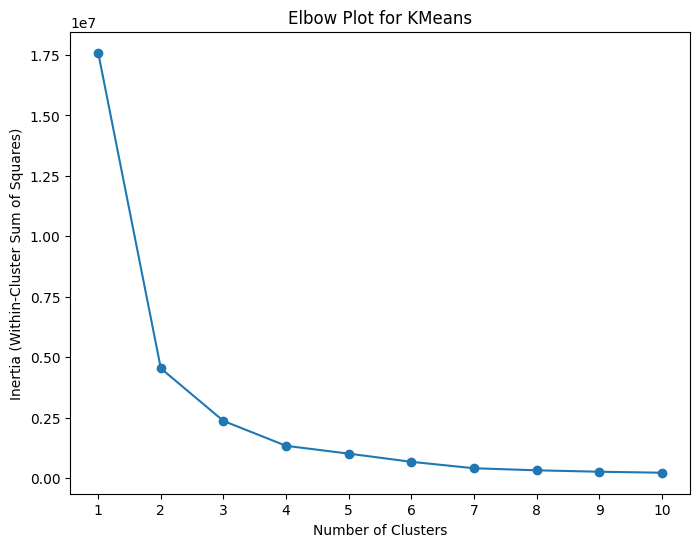

In [9]:
# Calculate within-cluster sum of squares for different numbers of clusters
inertia_values = []
for n_clusters in range(1, 11):
    kmeans = KMeans(n_clusters=n_clusters, n_init='auto')
    kmeans.fit(X)
    inertia_values.append(kmeans.inertia_)

# Plot the elbow plot
plt.figure(figsize=(8, 6))
plt.plot(range(1, 11), inertia_values, marker='o')
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia (Within-Cluster Sum of Squares)')
plt.title('Elbow Plot for KMeans')
plt.xticks(np.arange(1, 11))
plt.show()

Looking at the above graph, the rate of change fo the graph seems to start to slow down around 3 to 4 clusters, so I would say that the optimal number of clusters based on this elbow plot is 3 (this is a bit of a subjective measure however). Perhaps a better way to determine the optimal number of clusters is using a silhouette score, which is a measure of how well-separated and distinct the predicted clusters are. If the sihlouette score is close to +1 then the data is well clustered with the given number of clusters and there is a clear separation between the clusters. A score close to 0 means that the clusters are overlapping and crowded, and a score close to -1 means the data may have been misclassified.  Therefore, we can create a plot of the number fo clusters on the x-axis and the sihlouette score on the y-axis and find the number of clusters that maximizes the silhouette score.

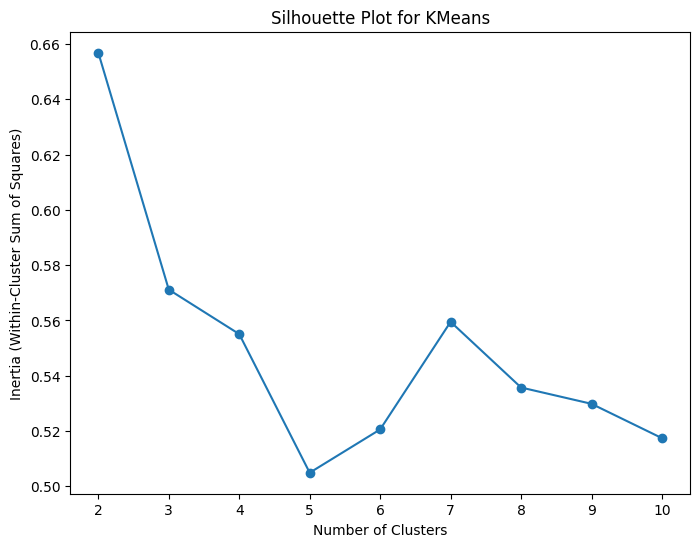

In [10]:
# Calculate within-cluster sum of squares for different numbers of clusters
silhouette_values = []
for n_clusters in range(2, 11):
    kmeans = KMeans(n_clusters=n_clusters, n_init='auto')
    kmeans.fit(X)
    silhouette_values.append(silhouette_score(X, kmeans.labels_))

# Plot the elbow plot
plt.figure(figsize=(8, 6))
plt.plot(range(2, 11), silhouette_values, marker='o')
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia (Within-Cluster Sum of Squares)')
plt.title('Silhouette Plot for KMeans')
plt.show()

Based on the silhouette plot, the best number of clusters for the data set is actually 2, with the second-best number of clusters being 3. Remembering the pairplot with the overlapping clusters in many of the plots, it does make sense why two distinct clusters in feature space may score higher than three distinct clusters if the number of categories is not known. 

There are some problems when it comes to using k-means.  The centroids need to be initialized at the start of the program and the convergence criteria needs to be decided.  The Scikit-Learn implementation provides defaults for both of these.  The default convergence criteria should be fine, but it is worth discussing two different ways to initialize the centroids. The initial locations of the centroids can be randomly initialized, but these random locations may not be the best and thus this method can suffer from slow convergence.  Another initialization method is called KMeans++. It selects the initial centroid locations more intelligently using probability to find the most likely locations.  This method speeds up the convergence of the algorithm.

The choice of initialization method is important because k-means algorithms are sensitive to the initialization of the centroid locations.  They can also have difficulty handling outliers in the data set and it can be difficult to determine the optimal number of clusters in the data (requiring the creating of elbow plots and/or silhouette plots).



## Dimensionality Reduction

The next unsupervised learning learning task we will study is dimensionality reduction.  The goal of dimensionality reduction is to reduce the dimensions of the data (the number of features) wile preserving the essential information needed to train a supervised learning model. There are a view reasons we want to do dimensionality reduction. First, high dimensional data can lead to overfitting a supervised learning algorithm. Increased dimensions leads to increased complexity and ultimately to increased computational effeciencies. The data sets we will see in this class will have 20 feature or less, but in the real world its not uncommon to find data sets that have hundreds or thousands of features.  Trying to train a supervised learning model with all of this data will not only obsure the patterns that are important to train the model, but it will take a very long time as well.  Therefore, for data sets with many dimensions, we will employ dimensionality reduction to reduce the total number of features in hopes of improving the accuracy and the computational effeciency.

There are two main ways to reduce the dimensions of the data. The first is to reduce to total number of features through a process called feature selection. We have been doing feature selection by hand so far, but there are unsupervised learning methods which will perform feature selection as well. The second method to reduce dimension is called feature extracton, which creates entirely new features using patterns it finds in the original features.  Principal component analysis (PCA) used feature extration to create new features based off the current features. The general machine leanring workflow that uses dimensionality reduction will involve performing the dimensionality reduction (unsupervised learning) before then feeding the new data and the targets/labels into a regression or classification model to use as training data (supervised machine learning). If you train your model using features that have been altered using dimensionality reduction, then you need to also alter any test data points you pass into also needs to have its features altered with the same dimensionality reduction algorithm.

### Principal Component Analysis (PCA)
The dimensionality reduction algorithm we will be using this week is called principal component analysis, typically known as PCA. The goal of PCA is to perform dimensionality reduction to transform a high dimensional data set into a lower dimension while keeping as much of the variance of the data as possible. In the below example, to transform the 2D data into a one dimensional data set, there are many options (three are shown) but the top axis (label c1) keeps the most variance of the data (spread of the data).

![PCA](https://raw.githubusercontent.com/Akramz/Hands-on-Machine-Learning-with-Scikit-Learn-Keras-and-TensorFlow/63b8d7a91ff1ca2fdc35947a6a390c5a81085bd2//static/imgs/2D_variance_projection.png)

PCA has several benefits. It reduces both the noise and the complexity in the data. It can also help improve visualization by allowing high dimensional data to be brought down into a lower dimension in order to be plotted. Finally, by reducing the number of dimensions in the data set, the computational effeciency of the late supervised machine learning algorithm can be improved.

#### How does PCA Work?

The algorithm for PCA can be broken down into five steps. First, the data set needs to be standardized.  Unlike previous algorithms we have looked at here the data standardization is optional but can improve accuracy, the data for a PCA algorithm needs to be standardized. 

Secondly, the data needs to be used to create a covariance matrix. A convariance matrix is a matrix where each element is the covariance between two variables. Covariance is a measure of how two variables change together. Next, the eigenvectors and eigenvalues of the covariance matric are calculated.  These eigenvectors will become the _principal components_, which are used to create new features in the lower dimensional space. 

The eigenvectors which will be chosen as principal components will be used as the new features are chosen with the eigenvalues. The largest eigenvalues of the covariance matrix correspond to the eigenvectors (principal components) that capture the most data. Given N principal components, the N eigenvectors with the largest eigenvalues will be kept. 

Finally, the data is transformed into a lower dimension.  A transformation is created where the principal components are the columns and this transformation matrix is them multiplied by the original data to create the low dimension data set. In math terms, PCA is a projection from a high dimensional space into a lower dimension space.

#### Interpretability and Challenges

While PCA does have its benefits the drawbacks come from its interpretabolity and other challenges. The principal componenents can be interpreted as linear combinations of the original features but the lower dimensional data has not physical interpretation. This can make it very difficult ot make sense of the model that the lower dimensional data will be used to train.

There are alsp some limitations that come from PCA. The dimensionality reduction can lead to a potential loss of information. Complex relationships in the data can not be perserved. The data set must be scaled before it can be used which causes an extra step in the machine learning workflow. Finally, PCA workds best when there are correlations between features, which may not be true for all data sets.

#### Using PCA

To start out, let's attempt to reduce the number of features in the wine data set from 13 to 6 by setting the number of components to 6. Even with just this initial guess in the number of principal components, we are able to improve the accuracy of the SVC.


In [12]:
# Scale the data set
scaler = StandardScaler()
scaler.fit(X)
Z = scaler.transform(X)

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(Z, y, test_size=0.2)

# Perform PCA for dimensionality reduction
pca = PCA(n_components=6)  # Choose the number of principal components
X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.transform(X_test)

# Initialize the Support Vector Classifier
svc = SVC(kernel='linear', C=1.0, random_state=42)

# Train the SVC on the PCA-transformed training data
svc.fit(X_train_pca, y_train)

# Predict the classes on the PCA-transformed test data
y_pred = svc.predict(X_test_pca)

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.2f}")

Accuracy: 0.89


Though six components does improve the accuracy of the model, having more or less components may provide a larger improvement. In this sense, the number of principal components in a PCA algorithm can be viewed as a hyperparameter and this can be tuned using the methods we developed last week. First, let use the basic for loop to find the best number of components.

In [13]:
for i in range(1,13):
    # Perform PCA for dimensionality reduction
    pca = PCA(n_components=i)  # Choose the number of principal components
    X_train_pca = pca.fit_transform(X_train)
    X_test_pca = pca.transform(X_test)
    
    # Initialize the Support Vector Classifier
    svc = SVC(kernel='linear', C=1.0, random_state=42)
    
    # Train the SVC on the PCA-transformed training data
    svc.fit(X_train_pca, y_train)
    
    # Predict the classes on the PCA-transformed test data
    y_pred = svc.predict(X_test_pca)
    
    # Calculate accuracy
    accuracy = accuracy_score(y_test, y_pred)
    print("Number of Components:", i, f"Accuracy: {accuracy:.2f}")

Number of Components: 1 Accuracy: 0.78
Number of Components: 2 Accuracy: 0.92
Number of Components: 3 Accuracy: 0.94
Number of Components: 4 Accuracy: 0.94
Number of Components: 5 Accuracy: 0.89
Number of Components: 6 Accuracy: 0.89
Number of Components: 7 Accuracy: 0.94
Number of Components: 8 Accuracy: 0.97
Number of Components: 9 Accuracy: 0.97
Number of Components: 10 Accuracy: 0.97
Number of Components: 11 Accuracy: 0.94
Number of Components: 12 Accuracy: 0.94


For this data it looks like 8-10 components give the best accuracy (note this does highly depend on the train-test-split so the actual results will be different if you rerun the notebook). However, as we found last week, using a for loop for hyperparameter tuning can be clunky as Scikit-Learn provides several good hyperparameter tuning algorithms as well such as `GridSearchCV` and `RandomizedSearchCV`. We can use either of these methods to perform a search for the best number of hyperparameters.  

However, since the results for PCA will be directly fed into a supervised learning algorithm (in this case SVC), we also want to make sure we are tuning that algorithm using the PCA features.  But changing the number of PCA components will likely change the optimal parameters for the supervised learning algorithm, so we need to find a way to tune all of the data together.

Scikit-Learn makes a relatively simple method to do this called a `Pipeline`. A pipeline is just a list of the Scikit-Learn functions you want to use, passed to the `Pipeline` function in order. Note that the list passed to `Pipeline` contains tuples, with the first entry being a variable name for the component (as a string), and the second entry being the function call for the method. In the below example, our pipeline contains the standard scaler method, followed by PCA, and finishing with SVC. This means that when we pass data to the pipeline, first the data will pass through the scaler, then through PCA, and finally through the SVC.  Pipelines are fit and used to make predictions the same way as other Scikit-Learn functions.  You can read more about Pipelines [here](https://scikit-learn.org/stable/modules/generated/sklearn.pipeline.Pipeline.html). 

The convenient feature of Pipelines as they allow us to perform hyperparameter tuning collectively on all methods in the pipeline. This means that we can tune the number of components of our PCA algorithm (`pca__n_components` in the below example) at the same time we are tuning two hyperparameters of our SVC algorithm (`svc__C` and `svc__kernel` below). The below model performs this hyperparameter tuning using the Pipeline and then prints the hyperparameters that result in the best model and the best model accuracy.

In [14]:
# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(Z, y, test_size=0.2)

# Create a pipeline with PCA and SVC
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('pca', PCA()),
    ('svc', SVC())
])

# Define parameter distributions for RandomizedSearchCV
param_dist = {
    'pca__n_components': [2, 5, 8],  # Number of principal components
    'svc__C': uniform(0.1, 10),       # Regularization parameter C
    'svc__kernel': ['linear', 'rbf'], # Kernel type
}

# Initialize RandomizedSearchCV
random_search = RandomizedSearchCV(pipeline, param_distributions=param_dist, n_iter=100)

# Fit the RandomizedSearchCV on training data
random_search.fit(X_train, y_train)

# Print the best hyperparameters
print("Best Hyperparameters:", random_search.best_params_)

# Predict the classes on the test data
y_pred = random_search.predict(X_test)

# Calculate accuracy
accuracy = np.mean(y_pred == y_test)
print(f"Accuracy: {accuracy:.2f}")


Best Hyperparameters: {'pca__n_components': 8, 'svc__C': 2.1523720161520665, 'svc__kernel': 'rbf'}
Accuracy: 0.97


Finally, instead of specifying the number of PCA components we want in our algorithm (which is determined by passing a number greater than or equal to 1 to the `n_components` argument), we can instead specify the amount of variance in the data we want to be kept (by passing a number between 0.0 and 1.0) and letting the PCA figure out the number of components that are needed. Usually, but not always, more variance will lead to greater accuracy and to achieve a higher kept variance more principal components will be needed. The below code is an example of keeping 95% of the variance and using that to determine the amount of PCA components that are needed.

In [15]:
pca = PCA(n_components=0.95)  # Choose the variance
X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.transform(X_test)

print("Number of PCA Components:", pca.n_components_)

# Initialize the Support Vector Classifier
svc = SVC(kernel='linear', C=1.0, random_state=42)

# Train the SVC on the PCA-transformed training data
svc.fit(X_train_pca, y_train)

# Predict the classes on the PCA-transformed test data
y_pred = svc.predict(X_test_pca)

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.2f}")

Number of PCA Components: 10
Accuracy: 0.92


To more thoroughly investigate the relationship between variance kept, number of PCA components, and accuracy, we can create the following plot. The x-axis is the amount of variance we specify the PCA algorithm to keep and there are two things plotted on the y-axis. The red data specifies the number of components that are needed in order to achieve that variance. The blue data is the accuracy of the model multiplied by 10 (in order to set the scales to the same values). We can see that to achieve higher variance we have to increase the number of components in the model and that a higher amount of variance typically increases the accuracy of the model (sometimes not always depending on the data split).

Text(0, 0.5, 'See Legend')

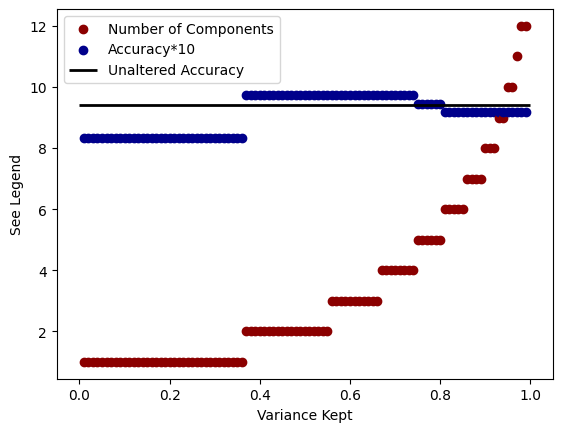

In [17]:
for i in range(1,100):
    i /= 100

    pca = PCA(n_components=i)  # Choose the number of principal components
    X_train_pca = pca.fit_transform(X_train)
    X_test_pca = pca.transform(X_test)
    
    plt.scatter(i,pca.n_components_, color='darkred', label='Number of Components'if i == 0.99 else "_nolegend_")

    # Initialize the Support Vector Classifier
    svc = SVC(kernel='linear', C=1.0, random_state=42)
    
    # Train the SVC on the PCA-transformed training data
    svc.fit(X_train_pca, y_train)
    
    # Predict the classes on the PCA-transformed test data
    y_pred = svc.predict(X_test_pca)
    
    # Calculate accuracy
    accuracy = accuracy_score(y_test, y_pred)

    plt.scatter(i,accuracy*10, color='darkblue', label='Accuracy*10'if i == 0.99 else "_nolegend_")

plt.hlines(9.4, 0.0, 1.0, linewidth=2, color='k', label="Unaltered Accuracy")
plt.legend()
plt.xlabel("Variance Kept")
plt.ylabel("See Legend")